This notebook shows the process to extract the ROI (1.35km x 1.35km squared image centered on the site) from Sentinel-2 raw images. Meanwhile the calculation of NIRV reflectance is calculated and therefore the output image will only contain the values of NIRV reflactance. 

In [1]:
import os
# import math
import shapely as shp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.mask

In [2]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

### 1. Read all the Sentinel-2 raw images

In [3]:
# Get the names of the folders in the raw image directory
list_Raw_Name = os.listdir(cwd_Images_Raw)
list_Raw_Name

['Havard Forest', 'San Rossore']

In [4]:
# Get paths to all the 10m-resolution .jp2 files
list_Raw_10m = []
for raw_Name in list_Raw_Name:
    # Create a temporary list to store the paths to all the 10m-resolution .jp2
    temp_List = []
    # Find all the files under the directory and filter out those irrelevant
    for path, subdirs, files in os.walk(cwd_Images_Raw + "\\" + raw_Name + "\\L2A"):
        for name in files:
            temp = os.path.join(path, name)
            if temp[-3:] == 'jp2' and "B0" in temp and "10m" in temp:
                # print(temp)
                temp_List.append(temp)
    list_Raw_10m.append(temp_List)
del raw_Name, temp, temp_List
list_Raw_10m[0]

['c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B02_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B03_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B04_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B08_10m.jp2']

In [5]:
# Read them via rasterio package
list_Image_10m = []
for item in list_Raw_10m[0]:
    temp = rio.open(item)
    list_Image_10m.append(temp)
list_Image_10m[2]

<open DatasetReader name='c:/Users/m1865/Desktop/DISC/Sentinel-2 Images Raw/Havard Forest/L2A/S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE/GRANULE/L2A_T18TYN_A002182_20170806T153908/IMG_DATA/R10m/T18TYN_20170806T153909_B04_10m.jp2' mode='r'>

In [10]:
list_Image_10m[2].meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 4800000.0)}

: 

In [9]:
# Get the 2d array by reading the band
list_Band_10m = []
for item in list_Image_10m:
    temp = item.read(1)
    list_Band_10m.append(temp)
list_Band_10m[2].max()

17840

In [8]:
list_Band_10m[2].astype(float)

array([[1314., 1496., 1682., ..., 1586., 1370., 1188.],
       [1296., 1361., 1468., ..., 1718., 1476., 1241.],
       [1278., 1325., 1326., ..., 1758., 1530., 1284.],
       ...,
       [1219., 1210., 1223., ..., 1481., 1319., 1368.],
       [1234., 1231., 1226., ..., 1666., 1396., 1522.],
       [1212., 1236., 1222., ..., 1906., 1474., 1668.]])

### 2. Read sites information

In [32]:
df_Sites = pd.read_csv(cwd + "\\Site.csv")
df_Sites.iloc[[5],:]

,Site,Serial Number,Country,Latitude,Longitude
5,San Rossore 2,JB-019-MR,Italy,43.732,10.291


### 3. Create a shapefile of the site San Rossore 2

In [35]:
# Create a point shapefile based on the site, using Lon-Lat
gdf_4326 = gpd.GeoDataFrame(
    df_Sites.iloc[[5],:],
    geometry = gpd.points_from_xy(df_Sites.iloc[[5],:]['Longitude'], df_Sites.iloc[[5],:]['Latitude']),
    crs = "EPSG:4326"
)

In [37]:
# Converting Lon-Lat to UTM coordinates
gdf_32632 = gdf_4326.copy()
gdf_32632 = gdf_32632.to_crs('EPSG:32632')
gdf_32632

,Site,Serial Number,Country,Latitude,Longitude,geometry
5,San Rossore 2,JB-019-MR,Italy,43.732,10.291,POINT (603969.946 4842917.171)


In [89]:
gdf_32632.to_file(cwd + "\\test.shp")

C:\Users\m1865\AppData\Local\Temp\ipykernel_24476\3819757163.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_32632.to_file(cwd + "\\test.shp")


### 4. Assign the site to a pixel, and then create a 900 m x 900m and 1350 m x 1350 m square geodataframe

In [104]:
# Get the bounds of the Sentinel-2 images to have an idea
list_Image_10m[0].bounds

BoundingBox(left=600000.0, bottom=4790220.0, right=709800.0, top=4900020.0)

In [98]:
site_x = gdf_32632.geometry.x.values[0]
site_y = gdf_32632.geometry.y.values[0]
site_x_Round = round(site_x/10)*10
site_y_Round = round(site_y/10)*10
print(str(site_x_Round) + " " + str(site_y_Round))

603970 4842920


In [100]:
bound_x_min_900 = site_x_Round - 450
bound_x_max_900 = site_x_Round + 450
bound_y_min_900 = site_y_Round - 450
bound_y_max_900 = site_y_Round + 450
shp_900 = shp.box(bound_x_min_900, bound_y_min_900, bound_x_max_900, bound_y_max_900)

<Axes: >

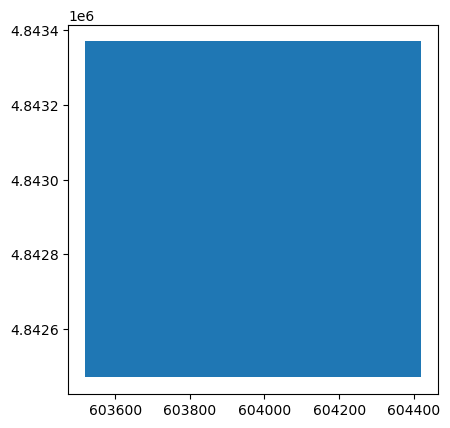

In [108]:
gdf_900 = gpd.GeoDataFrame(
    [1],
    geometry=[shp_900],
    crs = "EPSG:32632"
)
gdf_900.plot()

In [115]:
bound_x_min_1350 = site_x_Round - 680
bound_x_max_1350 = site_x_Round + 680
bound_y_min_1350 = site_y_Round - 680
bound_y_max_1350 = site_y_Round + 680
shp_1350 = shp.box(bound_x_min_1350, bound_y_min_1350, bound_x_max_1350, bound_y_max_1350)

In [116]:
gdf_1350 = gpd.GeoDataFrame(
    [1],
    geometry=[shp_1350],
    crs = "EPSG:32632"
)

### 5. Calculate NIRV reflectance, ...

In [142]:
# NIRV reflectance: NIRV_ref = NDVI * NIR = (B8 - B4) / (B8 + B4) * B8
# Pay attention to the data format. In Sentinel-2 raw images, all the values are unsigned int 16. 
NIRV_ref = (list_Band_10m[3].astype(float) - list_Band_10m[2].astype(float)) / (list_Band_10m[3].astype(float) + list_Band_10m[2].astype(float)) * list_Band_10m[3].astype(float)
NIRV_ref

array([[3135.50887762, 3186.65392417, 3196.617601  , ..., 2512.96461337,
        3065.97418562, 3734.66361493],
       [3055.29362253, 3095.66512959, 3172.35200629, ..., 3270.44057588,
        3047.53482774, 2712.72324895],
       [2982.65163195, 3161.84554267, 3250.44848012, ..., 2670.67826087,
        1929.46984969, 1652.39719383],
       ...,
       [ -10.89301503,  -16.25853659,  -13.3383592 , ...,  686.37950241,
         648.26561942,  533.36674903],
       [ -10.89367311,  -23.96997792,  -23.4893617 , ...,  680.4       ,
         517.3800634 ,  523.56546557],
       [ -12.85004437,  -23.488     ,  -13.3376392 , ...,  579.32727273,
         492.04780592,  484.32297249]])

In [143]:
src = list_Image_10m[0]
out_meta = src.meta
out_meta.update({
    "driver": "GTiff",
    "dtype": 'float64'
})
with rio.open(cwd_Images_Processed + "\\San Rossore\\NIRV Reflectance.tif", 'w', **out_meta) as dest:
    dest.write(NIRV_ref, 1)

### 6. Clip to the extent of 900m x 900m and 1350m x 1350m

In [144]:
src = rio.open(cwd_Images_Processed + "\\San Rossore\\NIRV Reflectance.tif")
out_image, out_transform = rio.mask.mask(src, gdf_900.geometry, crop=True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(cwd_Images_Processed + "\\San Rossore\\NIRV Reflectance 900m.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [145]:
src = rio.open(cwd_Images_Processed + "\\San Rossore\\NIRV Reflectance.tif")
out_image, out_transform = rio.mask.mask(src, gdf_1350.geometry, crop=True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(cwd_Images_Processed + "\\San Rossore\\NIRV Reflectance 1350m.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# hold

<Axes: >

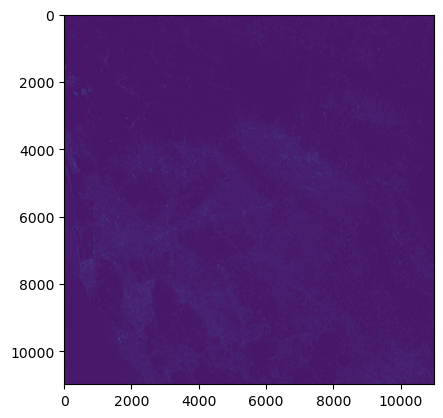

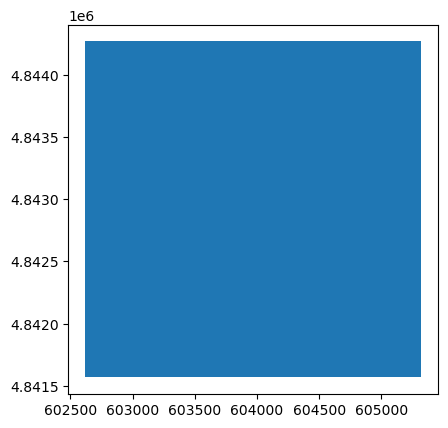

In [44]:
# Buffer the point shapefile to a polygon (square) shapefile, the side-length of which is 1350m (1.5 * 900m)
gdf_32632_Buffer = gdf_32632.copy()
gdf_32632_Buffer = gdf_32632_Buffer.buffer(1350, cap_style = 3)

plt.imshow(list_Image_10m[0])
gdf_32632_Buffer.plot()

### 2. Calculate NIRV reflectance, ...

In [ ]:
# NIRV reflectance: NIRV_ref = NDVI * NIR = (B8 - B4) / (B8 + B4) * B8

In [ ]:
# Read these files via rasterio
for raw_Name in list_Raw_10m:
    temp_List = []
    for 

In [34]:
a = rio.open(list_Raw_10m[0][0])
a

<open DatasetReader name='c:/Users/m1865/Desktop/DISC/Sentinel-2 Images Raw/S2B_MSIL2A_20230730T101609_N0509_R065_T32TPP_20230730T131511.SAFE/GRANULE/L2A_T32TPP_A033410_20230730T102200/IMG_DATA/R10m/T32TPP_20230730T101609_B02_10m.jp2' mode='r'>

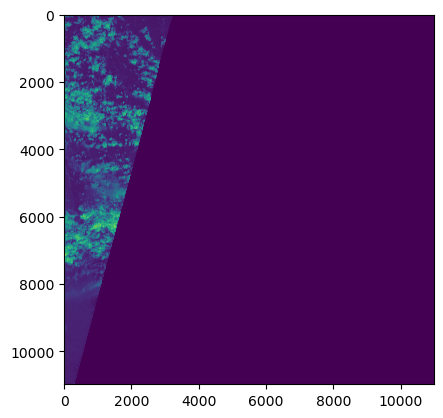

In [35]:
plt.imshow(a.read(1))